# Data source:
https://www.kaggle.com/yamaerenay/spotify-dataset-19212020-160k-tracks

# Links
https://developer.spotify.com/documentation/web-api/reference/tracks/get-audio-features/

# Najpopularniejsze utwory 2020

In [1]:
%%html
<iframe src="https://open.spotify.com/embed/track/0VjIjW4GlUZAMYd2vXMi3b" width="300" height="380" frameborder="0" allowtransparency="true" allow="encrypted-media"></iframe>
<iframe src="https://open.spotify.com/embed/track/7ytR5pFWmSjzHJIeQkgog4" width="300" height="380" frameborder="0" allowtransparency="true" allow="encrypted-media"></iframe>
<iframe src="https://open.spotify.com/embed/track/7eJMfftS33KTjuF7lTsMCx" width="300" height="380" frameborder="0" allowtransparency="true" allow="encrypted-media"></iframe>


In [2]:
from mpl_toolkits.mplot3d import Axes3D
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt # plotting
import numpy as np; np.random.seed(0)
import seaborn as sns; sns.set_theme()
import os # accessing directory structure
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

df_data = pd.read_csv('./kaggle_data/data.csv', delimiter=',')

#df_data_w_generes = pd.read_csv('./kaggle_data/data_w_genres.csv', delimiter=',')
#df_data_by_artist = pd.read_csv('./kaggle_data/data_by_artist.csv', delimiter=',')
#df_data_by_genres = pd.read_csv('./kaggle_data/data_by_genres.csv', delimiter=',')
#df_data_by_year = pd.read_csv('./kaggle_data/data_by_year.csv', delimiter=',')

plt.rcParams['figure.figsize'] = [15, 5]

### Pozbywamy się kolumn które nas nie interesują
* id - identyfikator utworu
* acousticness - czy utwór jest akustyczny czy nie
* energy - "energia" utworu niezbyt dokładnie opisana w dokumentacji - zdeydowaliśmy się zachować podobny paramentr - valence - określający "pozytywność" utworu, co w naszej opini ma większe znaczenie w naszym temacie
* release_date - pokrywa się z rokiem
* mode - wartość binarna 0/1
* key - główny ton utworu
* loudness - wartość w dB

In [3]:
df_new = df_data.copy()

df_new = df_new.drop(columns=['id',
                              'acousticness',
                              'explicit',
                              'energy',
                              'release_date',
                              'mode',
                              'key',
                              'loudness'])
df_new.head(5)

,artists,danceability,duration_ms,instrumentalness,liveness,name,popularity,speechiness,tempo,valence,year
0,['Carl Woitschach'],0.708,158648,0.563,0.1510,Singende Bataillone 1. Teil,0,0.0506,118.469,0.7790,1928
1,"['Robert Schumann', 'Vladimir Horowitz']",0.379,282133,0.901,0.0763,"Fantasiestücke, Op. 111: Più tosto lento",0,0.0462,83.972,0.0767,1928
2,['Seweryn Goszczyński'],0.749,104300,0.000,0.1190,Chapter 1.18 - Zamek kaniowski,0,0.9290,107.177,0.8800,1928
3,['Francisco Canaro'],0.781,180760,0.887,0.1110,Bebamos Juntos - Instrumental (Remasterizado),0,0.0926,108.003,0.7200,1928
4,"['Frédéric Chopin', 'Vladimir Horowitz']",0.210,687733,0.908,0.0980,"Polonaise-Fantaisie in A-Flat Major, Op. 61",1,0.0424,62.149,0.0693,1928


# Przygotowanie i czyszczenie danych

Pierwszym krokiem jest zamiana ms na sekundy

In [4]:
df_new['duration'] = df_new['duration_ms'].map(lambda a: a/1000)
df_new = df_new.drop(columns=['duration_ms'])
#df_new

### czas < 30s

Pozbywamy się utworów krótszych niż 30 sekund

In [5]:
%%html
<iframe src="https://open.spotify.com/embed/track/17aXSvwW1WughiCvxAyLGj" width="300" height="380" frameborder="0" allowtransparency="true" allow="encrypted-media"></iframe>

In [6]:
df_new.drop(df_new[df_new.duration < 30].index, inplace=True)
print(f"Wszystkie dane: {df_data.shape[0]}")
print(f"Zachowane dane: {df_new.shape[0]}")
print(f"Usuniety % wszystkich rekordów: {(1 - df_new.shape[0]/ df_data.shape[0]) * 100}%")

Wszystkie dane: 169909
Zachowane dane: 169724
Usuniety % wszystkich rekordów: 0.10888181320589663%


### tempo = 0

Jak już wcześniej ustaliliśmy tempo 0 nie ma sensu a co za tym idzie odrzucamy takie dane

In [7]:
%%html
<iframe src="https://open.spotify.com/embed/track/7cctPQS83y620UQtMd1ilL" width="300" height="380" frameborder="0" allowtransparency="true" allow="encrypted-media"></iframe>

In [8]:
temp = df_new.shape[0]
df_new.drop(df_new[df_new.tempo == 0].index, inplace=True)
print(f"Wszystkie dane: {df_data.shape[0]}")
print(f"Zachowane dane: {df_new.shape[0]}")
print(f"Usuniety % wszystkich rekordów: {(1 - df_new.shape[0] / df_data.shape[0]) * 100}%")
print("wliczamy wszystkie poprzednie operacje - czyli usunelismy te o durr < 30 i tempo = 0")

Wszystkie dane: 169909
Zachowane dane: 169598
Usuniety % wszystkich rekordów: 0.18303915625422773%
wliczamy wszystkie poprzednie operacje - czyli usunelismy te o durr < 30 i tempo = 0


In [9]:
# czyste dane gotowe do analizy i eksploracji
df_ready_data = df_new.copy()

# Statystyki

Dalsze obliczenia nie mają sensu dla wartości nienumerycznych. Dodatkowo nie ma to sensu dla roku który jest interpretowany jako bardziej opisowy, a nie liczbowy.

In [10]:
df_ready_data_numeric = df_ready_data.copy()
df_ready_data_numeric = df_ready_data_numeric.drop(columns=['artists', 'name', 'year'])

In [11]:
df_ready_data_numeric_sum = pd.DataFrame(df_ready_data_numeric.isnull().sum(), columns = ["missing"])
df_ready_data_numeric_max = pd.DataFrame(df_ready_data_numeric.max(), columns = ["max"])
df_ready_data_numeric_min = pd.DataFrame(df_ready_data_numeric.min(), columns = ["min"])
df_ready_data_numeric_mean = pd.DataFrame(df_ready_data_numeric.mean(), columns = ["mean"])
df_ready_data_numeric_median = pd.DataFrame(df_ready_data_numeric.median(), columns = ["median"])
df_ready_data_numeric_std = pd.DataFrame(df_ready_data_numeric.std(), columns = ["std"])

frames = [df_ready_data_numeric_sum,
         df_ready_data_numeric_max,
         df_ready_data_numeric_min,
         df_ready_data_numeric_mean,
         df_ready_data_numeric_median,
         df_ready_data_numeric_std]

df_statistics = pd.concat(frames, axis=1)
df_statistics

,missing,max,min,mean,median,std
danceability,0,0.988,0.0551,0.538683,0.548000,0.174688
instrumentalness,0,1.000,0.0000,0.161462,0.000202,0.308894
liveness,0,1.000,0.0000,0.206504,0.135000,0.176597
popularity,0,100.000,0.0000,31.582530,34.000000,21.562745
speechiness,0,0.969,0.0000,0.094023,0.045100,0.149703
tempo,0,244.091,30.9460,117.058009,114.829500,30.542035
valence,0,1.000,0.0000,0.532568,0.545000,0.261931
duration,0,4270.034,30.0000,231.641183,208.707000,120.524399


# Korelacja

Najwyższą korelacje osigaja cechy Year i Popularity ~ 0.88 <br>
Jednak chcemy mieć zarówno Year jak i Popularity więc nie łączymy żadnych danych

In [12]:
df_data_corr = df_data.corr()
df_data_corr

,acousticness,danceability,duration_ms,energy,explicit,instrumentalness,key,liveness,loudness,mode,popularity,speechiness,tempo,valence,year
acousticness,1.000000,-0.265950,-0.079311,-0.750283,-0.253690,0.335821,-0.021686,-0.023871,-0.567072,0.046475,-0.593345,-0.056077,-0.204982,-0.185540,-0.624550
danceability,-0.265950,1.000000,-0.134500,0.220569,0.241891,-0.281429,0.022599,-0.105532,0.294170,-0.045306,0.221077,0.225305,-0.004872,0.560242,0.203430
duration_ms,-0.079311,-0.134500,1.000000,0.036396,-0.043811,0.084814,-0.003116,0.034270,-0.014687,-0.046981,0.063292,-0.058449,-0.028816,-0.198760,0.076293
energy,-0.750283,0.220569,0.036396,1.000000,0.142677,-0.287692,0.029984,0.126293,0.782982,-0.038355,0.497488,-0.045226,0.249936,0.350086,0.532419
explicit,-0.253690,0.241891,-0.043811,0.142677,1.000000,-0.138292,0.008578,0.039272,0.152695,-0.083221,0.214044,0.413074,0.011484,-0.022327,0.245227
instrumentalness,0.335821,-0.281429,0.084814,-0.287692,-0.138292,1.000000,-0.014268,-0.047397,-0.417033,-0.035051,-0.299829,-0.115735,-0.107570,-0.193929,-0.291571
key,-0.021686,0.022599,-0.003116,0.029984,0.008578,-0.014268,1.000000,-0.000106,0.021920,-0.112766,0.010675,0.015225,0.003148,0.029064,0.012503
liveness,-0.023871,-0.105532,0.034270,0.126293,0.039272,-0.047397,-0.000106,1.000000,0.052985,0.005393,-0.075293,0.147667,0.008124,-0.000426,-0.055839
loudness,-0.567072,0.294170,-0.014687,0.782982,0.152695,-0.417033,0.021920,0.052985,1.000000,-0.013147,0.466546,-0.105796,0.211114,0.308418,0.490118
mode,0.046475,-0.045306,-0.046981,-0.038355,-0.083221,-0.035051,-0.112766,0.005393,-0.013147,1.000000,-0.032854,-0.057493,0.014539,0.014727,-0.033084


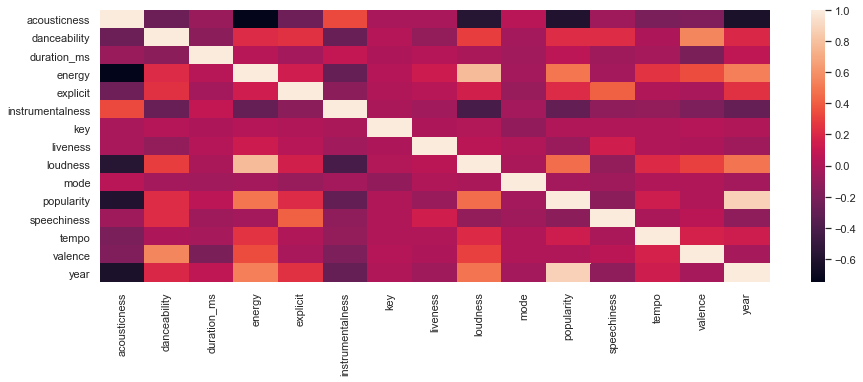

In [13]:
sns.heatmap(df_data_corr)

# Podstawowe wykresy

In [14]:
df_by_year = df_ready_data.groupby(['year']).aggregate({
    'duration': 'mean',
    'valence': 'mean',
    'danceability': 'mean',
    'instrumentalness': 'mean',
    'liveness': 'mean',
    'popularity': 'mean',
    'speechiness': 'mean',
    'tempo': 'mean',
    })

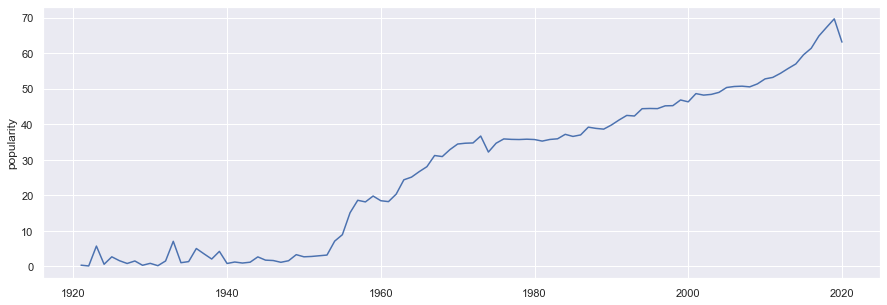

In [15]:
plt.plot(df_by_year["popularity"])
plt.ylabel("popularity")
plt.show()

### Popularność starych utworów
* Spotify zaczyna pełnoprawną działalność mniej więcej w roku 2010.
* Spotify celuje w młodsze osoby - tzw. "millenialsów"
* Ludzie młodzi raczej słuchają nowej muzyki
* Spotify promuje nowe piosenki poprzez tworzenie playlist

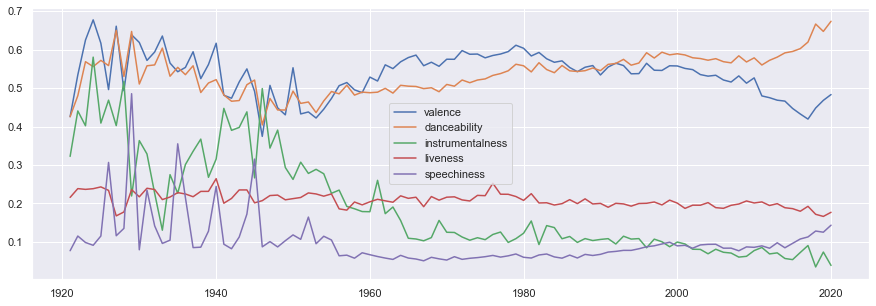

In [16]:
plt.plot(df_by_year["valence"])
plt.plot(df_by_year["danceability"])
plt.plot(df_by_year["instrumentalness"])
plt.plot(df_by_year["liveness"])
plt.plot(df_by_year["speechiness"])

plt.legend(["valence", "danceability", "instrumentalness", "liveness", "speechiness"])

### wojna i niepokoje społeczne
Poniżej 50' roku słaba jakość nagrań co może wprowadzać w błąd algorytm dostrojony do nowej muzyki
Przez 10 lat od zakończenia wojny - tendencja rozliczeniowa, od 55' zaczyna się normalna działalność **"dla radości"**

In [17]:
def plot_column_vs_duration(column):
    x = df_new.duration
    y = df_new[column]
    plt.xlim(0, 150)
    plt.ylabel(column)
    plt.xlabel("duration")
    plt.scatter(x, y, marker='.', alpha=0.05, cmap='viridis')

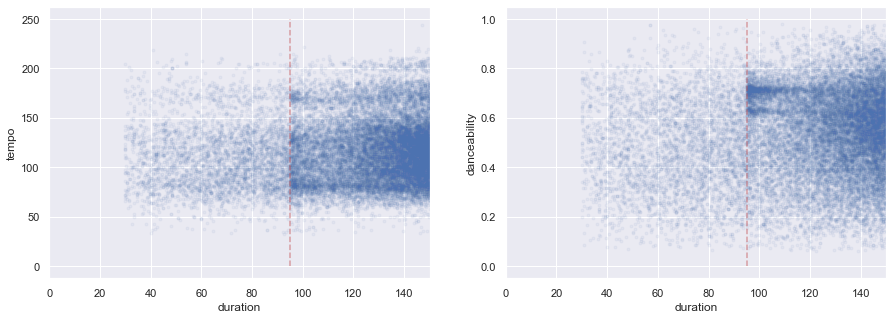

In [18]:
plt.subplot(1, 2, 1)
plot_column_vs_duration("tempo")
plt.plot([95, 95], [0,250], c='r', alpha=0.5, linestyle='--')

plt.subplot(1, 2, 2)
plot_column_vs_duration("danceability")
plt.plot([95, 95], [0,1], c='r', alpha=0.5, linestyle='--')

### Długość poniżej 95 sekund
Moze to wynikac ze sposobu dzialania algorytmu spotify lub z takich rzeczy jak umowy z wydawcami bo nie da sie po prostu wrzucac muzyki na spotify

# Elementy Odosobnione - metoda kwartyli

In [19]:
def plot_quar(df, quartile_2, lower_bound, upper_bound):
    m = quartile_2
    m_p3std = lower_bound
    m_n3std = upper_bound
    y = df
    x = range(len(y))
    plt.plot([0, len(y)], [m, m], c='r', linestyle='--')
    plt.plot([0, len(y)], [m_p3std, m_p3std], c='r', linestyle=':')
    plt.plot([0, len(y)], [m_n3std, m_n3std], c='r', linestyle=':')
    plt.scatter(x, y, marker='.', alpha=0.05, cmap='viridis')
    plt.ylabel(column)
    plt.xticks([])
    plt.show()

In [20]:
list_outliers = []

def outliers_iqr(ys):
    quartile_1, quartile_2, quartile_3 = np.percentile(ys, [25, 50, 75])
    iqr = quartile_3 - quartile_1
    lower_bound = quartile_2 - 2.2*(quartile_3 - quartile_1)
    upper_bound = quartile_2 + 2.2*(quartile_3 - quartile_1)
    
    plot_quar(ys, quartile_2, lower_bound, upper_bound)
    
    df_filled_out = pd.DataFrame(df_ready_data_numeric[((ys > upper_bound) | (ys < lower_bound))][column]).join(df_data['name'])
    list_outliers.extend(df_filled_out.index)
    display(df_filled_out)

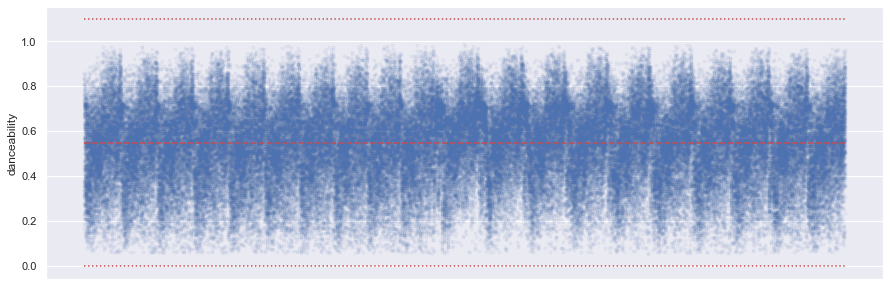

,danceability,name


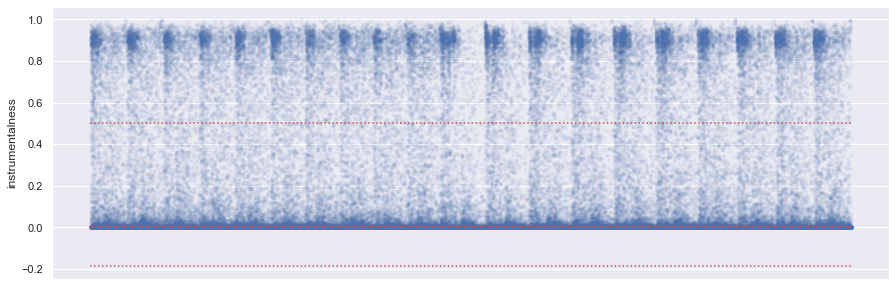

,instrumentalness,name
0,0.563,Singende Bataillone 1. Teil
1,0.901,"Fantasiestücke, Op. 111: Più tosto lento"
3,0.887,Bebamos Juntos - Instrumental (Remasterizado)
4,0.908,"Polonaise-Fantaisie in A-Flat Major, Op. 61"
5,0.911,Scherzo a capriccio: Presto
...,...,...
169710,0.779,Sangre
169717,0.988,Sounds of Nature: Thunder
169737,0.679,Tears of the City
169755,0.966,Soft Rain Pouring


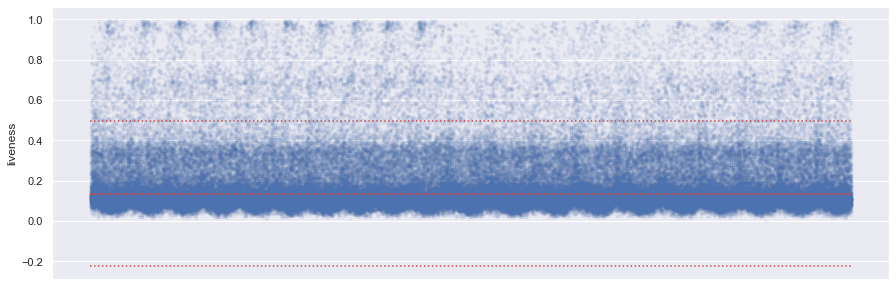

,liveness,name
55,0.593,I'd Rather Cry Over You
103,0.637,Μπεστενγκιάρ μανές
119,0.877,Edward the VIII
150,0.782,Siete Lágrimas - Remasterizado
192,0.666,Μου έδωσες την καρδούλα σου
...,...,...
169795,0.776,Out My Way
169827,0.706,Prices
169840,0.583,God Is Perfect
169864,0.588,No Regrets (feat. Don Toliver)


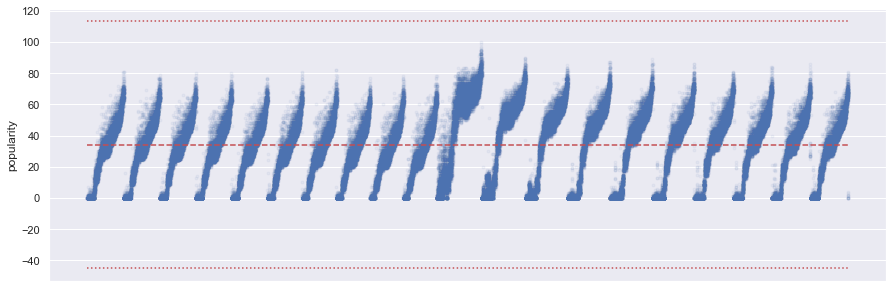

,popularity,name


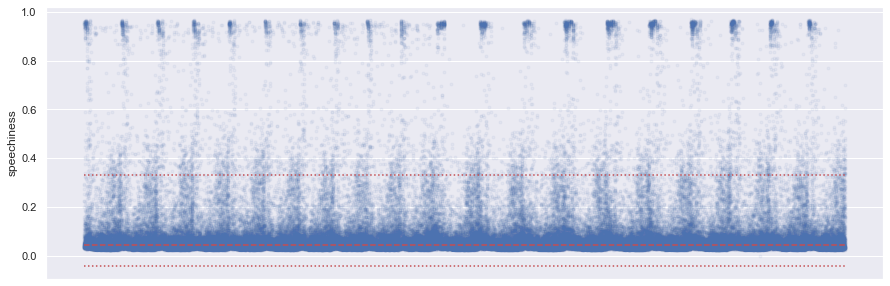

,speechiness,name
2,0.929,Chapter 1.18 - Zamek kaniowski
9,0.954,Chapter 1.3 - Zamek kaniowski
29,0.948,Chapter 4.12 - Zamek kaniowski
38,0.957,Chapter 4.10 - Zamek kaniowski
39,0.952,Chapter 2.11 - Zamek kaniowski
...,...,...
169888,0.359,Mr. Officer (feat. Queen Naija and members of ...
169890,0.391,Second Chances. (ft. 6LACK)
169895,0.553,Vibes Only
169897,0.355,Tycoon


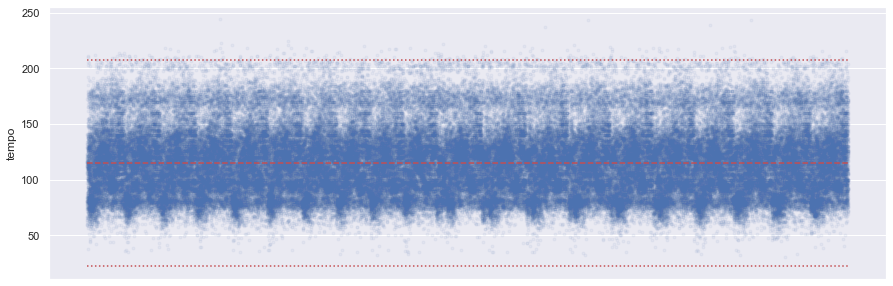

,tempo,name
146,210.173,Pantaleón - Remasterizado
280,211.089,Me Has Robado El Corazón
1832,212.242,Rocks In My Bed
2017,207.667,East of the Sun
5628,209.041,Return Of The Fly
...,...,...
165740,211.186,Protection
168319,208.706,I Wonder Why - Remastered
168550,209.774,El Favor De La Soledad
168581,207.576,Sun in an Empty Room


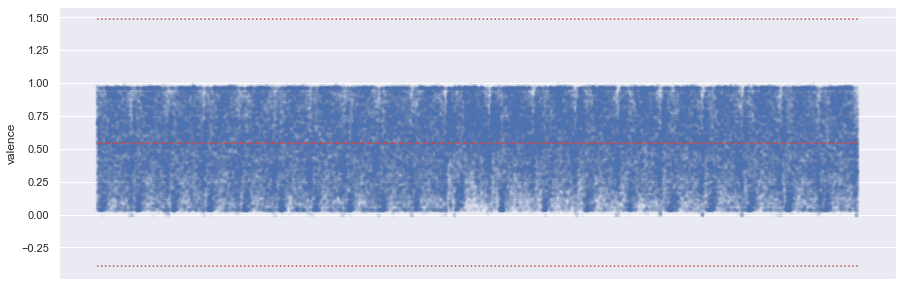

,valence,name


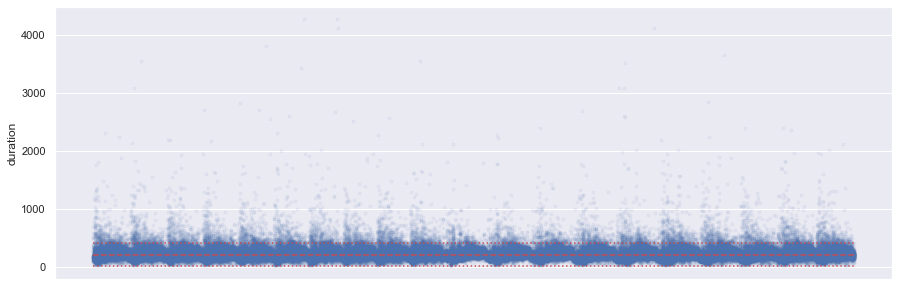

,duration,name
4,687.733,"Polonaise-Fantaisie in A-Flat Major, Op. 61"
10,590.293,"Piano Sonata No. 2 in B-Flat Minor, Op. 36: I...."
27,505.920,"Scherzo No. 1 in B Minor, Op. 20"
49,491.333,"Danse macabre, S. 555 (after Camille Saint-Saens)"
54,519.933,"Barcarolle, Op. 60"
...,...,...
169299,538.760,Will The Circle Be Unbroken - Live
169358,489.361,Outback (Extended Remix)
169398,417.693,Ok Alright (feat. ScHoolboy Q)
169509,412.632,Me Mata


In [21]:
for column in df_ready_data_numeric:
    if (column == "speechiness"):
        quartile_1, quartile_2, quartile_3 = np.percentile(df_ready_data_numeric["speechiness"], [25, 50, 75])
        iqr = quartile_3 - quartile_1
        lower_bound = quartile_2 - 2.2*(quartile_3 - quartile_1)
        upper_bound = 0.33

        plot_quar(df_ready_data_numeric["speechiness"], quartile_2, lower_bound, upper_bound)

        df_filled_out = pd.DataFrame(df_ready_data_numeric[((df_ready_data_numeric["speechiness"] > upper_bound) | (df_ready_data_numeric["speechiness"] < lower_bound))][column]).join(df_data['name'])
        list_outliers.extend(df_filled_out.index)
        display(df_filled_out)
    elif (column == "instrumentalness"):
        quartile_1, quartile_2, quartile_3 = np.percentile(df_ready_data_numeric["instrumentalness"], [25, 50, 75])
        iqr = quartile_3 - quartile_1
        lower_bound = quartile_2 - 2.2*(quartile_3 - quartile_1)
        upper_bound = 0.5

        plot_quar(df_ready_data_numeric["instrumentalness"], quartile_2, lower_bound, upper_bound)

        df_filled_out = pd.DataFrame(df_ready_data_numeric[((df_ready_data_numeric["instrumentalness"] > upper_bound) | (df_ready_data_numeric["speechiness"] < lower_bound))][column]).join(df_data['name'])
        list_outliers.extend(df_filled_out.index)
        display(df_filled_out)
    else:
        outliers_iqr(df_ready_data_numeric[column])

### Opis parametrów
* instrumentalness < 0.5
* speechiness < 0.33

inaczej pozbędziemy się za dużo danych

### Przykłady elementów odosobnionych

In [22]:
%%html
<iframe src="https://open.spotify.com/embed/track/6L63VW0PibdM1HDSBoqnoM" width="300" height="380" frameborder="0" allowtransparency="true" allow="encrypted-media"></iframe>
<iframe src="https://open.spotify.com/embed/track/5PXuSSMvae2tJuQj78DR5d" width="300" height="380" frameborder="0" allowtransparency="true" allow="encrypted-media"></iframe>
<iframe src="https://open.spotify.com/embed/track/0MAXHRBvH3yjPrmaIk0ela" width="300" height="380" frameborder="0" allowtransparency="true" allow="encrypted-media"></iframe>

### Odrzucenie elementów odosobnionych

In [23]:
list_outliers = list(dict.fromkeys(list_outliers))
df_data_without_outliers_quartile = df_ready_data.copy()
df_data_without_outliers_quartile = df_data_without_outliers_quartile.drop(list_outliers)

# Klasteryzacja

In [24]:
df_data_without_outliers_quartile_numeric = df_data_without_outliers_quartile.copy()
df_data_without_outliers_quartile_numeric = df_data_without_outliers_quartile_numeric.drop(columns=['artists', 'name', 'year'])
#df_data_without_outliers_quartile_numeric

### Normalizacja

In [25]:
import matplotlib.pyplot as plt
from kneed import KneeLocator
from sklearn.datasets import make_blobs
from sklearn.cluster import KMeans
from sklearn_extra.cluster import KMedoids
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import silhouette_score

In [26]:
df_data_without_outliers_quartile_numeric_normalized = df_data_without_outliers_quartile_numeric.copy()

In [27]:
df_data_without_outliers_quartile_numeric_normalized = pd.DataFrame(MinMaxScaler().fit_transform(df_data_without_outliers_quartile_numeric))
df_data_without_outliers_quartile_numeric_normalized.columns = df_data_without_outliers_quartile_numeric.columns

In [28]:
import matplotlib.cm as cm
from mpl_toolkits.mplot3d import Axes3D

def plot_clusters(x_column, y_column, df, clusters_data):
    colors = cm.nipy_spectral(clusters_data.labels_.astype(float) / len(clusters_data.cluster_centers_))

    x = df[x_column]
    y = df[y_column]

    plt.scatter(x, y, marker='.', s=30, lw=0, alpha=0.7, c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusters_data.cluster_centers_
    # Draw white circles at cluster centers
    plt.scatter(centers[:, df.columns.get_loc(x_column)],
                centers[:, df.columns.get_loc(y_column)],
                marker='o', c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        plt.scatter(c[df.columns.get_loc(x_column)],
                    c[df.columns.get_loc(y_column)],
                    marker='$%d$' % i, alpha=1, s=50, edgecolor='k')
    
    plt.xlabel(x_column)
    plt.ylabel(y_column)
    
    plt.show()

In [29]:
def plot_clusters_3d(x_column, y_column, z_column, df, clusters_data):
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    colors = cm.nipy_spectral(clusters_data.labels_.astype(float) / len(clusters_data.cluster_centers_))

    x = df[x_column]
    y = df[y_column]
    z = df[z_column]

    ax.scatter(x, y, z, marker='.', s=5, lw=0, alpha=0.5, c=colors, edgecolor='k')

    # Labeling the clusters
    centers = clusters_data.cluster_centers_
    # Draw white circles at cluster centers
    ax.scatter(centers[:, df.columns.get_loc(x_column)],
                centers[:, df.columns.get_loc(y_column)],
                centers[:, df.columns.get_loc(z_column)],
                marker='o', c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax.scatter(c[df.columns.get_loc(x_column)],
                    c[df.columns.get_loc(y_column)],
                    c[df.columns.get_loc(z_column)],
                    marker='$%d$' % i, alpha=1, s=50, edgecolor='k')
    
    ax.set_xlabel(x_column)
    ax.set_ylabel(y_column)
    ax.set_zlabel(z_column)

### KMeans

In [30]:
df_quartile_selected_params = df_data_without_outliers_quartile_numeric_normalized.drop(columns = [
    "valence",
    "instrumentalness",
    "liveness",
    "speechiness",
    "duration",
])

kmeans_selected = KMeans(
    init="random",
    n_clusters=3,
    n_init=10,
    max_iter=300,
    random_state=43)

cluster_data_selected = kmeans_selected.fit(df_quartile_selected_params)

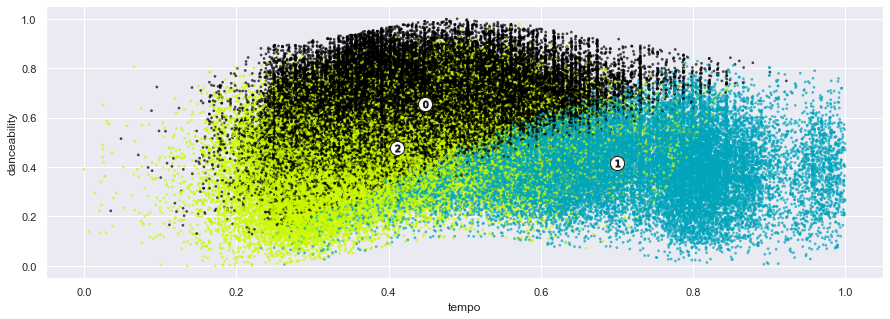

In [31]:
plot_clusters("tempo", "danceability", df_quartile_selected_params, cluster_data_selected)

### Przykład klasteryzacji - 50 klastrów

In [ ]:
kmeans_selected = KMeans(
    init="random",
    n_clusters=50,
    n_init=10,
    max_iter=300,
    random_state=43)

cluster_data_selected = kmeans_selected.fit(df_data_without_outliers_quartile_numeric_normalized)

In [ ]:
plot_clusters("tempo", "danceability", df_data_without_outliers_quartile_numeric_normalized, cluster_data_selected)

In [ ]:
epsilon = 0.09

df_prew_step = df_data_without_outliers_quartile_numeric_normalized.copy()

clus_temp = cluster_data_selected
cluster_number = 33
df_temp = df_data_without_outliers_quartile_numeric_normalized.copy()

for column in df_data_without_outliers_quartile_numeric_normalized:
    data = df_temp[(df_temp[column] < (clus_temp.cluster_centers_[:, df_temp.columns.get_loc(column)][cluster_number] + epsilon)) &
                   (df_temp[column] > (clus_temp.cluster_centers_[:, df_temp.columns.get_loc(column)][cluster_number] - epsilon))]
    df_prew_step = df_prew_step.reset_index().merge(data, how='inner').set_index('index')
    
#print(df_prew_step)

temp = df_data_without_outliers_quartile.reset_index()
temp.iloc[df_prew_step.index]

In [ ]:
%%html
<iframe src="https://open.spotify.com/embed/track/11Ki2bHWXTEug0DAfKcDDD" width="300" height="380" frameborder="0" allowtransparency="true" allow="encrypted-media"></iframe>
<iframe src="https://open.spotify.com/embed/track/0HU8CeTestQjoRF2ekaLqx" width="300" height="380" frameborder="0" allowtransparency="true" allow="encrypted-media"></iframe>
<iframe src="https://open.spotify.com/embed/track/4smyzd6JsDctqs5Fy104LL" width="300" height="380" frameborder="0" allowtransparency="true" allow="encrypted-media"></iframe>


In [ ]:
epsilon = 0.048

df_prew_step = df_data_without_outliers_quartile_numeric_normalized.copy()

clus_temp = cluster_data_selected
cluster_number = 49
df_temp = df_data_without_outliers_quartile_numeric_normalized.copy()

for column in df_data_without_outliers_quartile_numeric_normalized:
    data = df_temp[(df_temp[column] < (clus_temp.cluster_centers_[:, df_temp.columns.get_loc(column)][cluster_number] + epsilon)) &
                   (df_temp[column] > (clus_temp.cluster_centers_[:, df_temp.columns.get_loc(column)][cluster_number] - epsilon))]
    df_prew_step = df_prew_step.reset_index().merge(data, how='inner').set_index('index')
    
#print(df_prew_step)

temp = df_data_without_outliers_quartile.reset_index()
temp.iloc[df_prew_step.index]

In [ ]:
%%html
<iframe src="https://open.spotify.com/embed/track/7oOOI85fVQvVnK5ynNMdW7" width="300" height="380" frameborder="0" allowtransparency="true" allow="encrypted-media"></iframe>
<iframe src="https://open.spotify.com/embed/track/0ZG7CssB5lM2ILgJhMGNVE" width="300" height="380" frameborder="0" allowtransparency="true" allow="encrypted-media"></iframe>
<iframe src="https://open.spotify.com/embed/track/3wrP2GVxWH8VpHPOsKhYgz" width="300" height="380" frameborder="0" allowtransparency="true" allow="encrypted-media"></iframe>


In [ ]:
epsilon = 0.048

df_prew_step = df_data_without_outliers_quartile_numeric_normalized.copy()

clus_temp = cluster_data_selected
cluster_number = 0
df_temp = df_data_without_outliers_quartile_numeric_normalized.copy()

for column in df_data_without_outliers_quartile_numeric_normalized:
    data = df_temp[(df_temp[column] < (clus_temp.cluster_centers_[:, df_temp.columns.get_loc(column)][cluster_number] + epsilon)) &
                   (df_temp[column] > (clus_temp.cluster_centers_[:, df_temp.columns.get_loc(column)][cluster_number] - epsilon))]
    df_prew_step = df_prew_step.reset_index().merge(data, how='inner').set_index('index')
    
#print(df_prew_step)

temp = df_data_without_outliers_quartile.reset_index()
temp.iloc[df_prew_step.index]

In [ ]:
%%html
<iframe src="https://open.spotify.com/embed/track/5aDK0TurEtiedVdT0a6k9a" width="300" height="380" frameborder="0" allowtransparency="true" allow="encrypted-media"></iframe>
<iframe src="https://open.spotify.com/embed/track/2MYfUH4Zo7gphaxmMVDrie" width="300" height="380" frameborder="0" allowtransparency="true" allow="encrypted-media"></iframe>
<iframe src="https://open.spotify.com/embed/track/2Ro9FLIVhPwIQopSr48oJT" width="300" height="380" frameborder="0" allowtransparency="true" allow="encrypted-media"></iframe>


# Klasyfikacja

In [ ]:
kmeans_selected = KMeans(
    init="random",
    n_clusters=3,
    n_init=10,
    max_iter=300,
    random_state=43)

cluster_data_selected = kmeans_selected.fit(df_data_without_outliers_quartile_numeric_normalized)

In [ ]:
plot_clusters("tempo", "danceability", df_data_without_outliers_quartile_numeric_normalized, cluster_data_selected)

In [ ]:
df_test_temp = df_data_without_outliers_quartile.copy().reset_index()

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

df_classification = df_data_without_outliers_quartile_numeric_normalized.copy()
clus_dat = cluster_data_selected
n_neighbors = 12

def kneighbours_clasifier_leave_one_out(index):
    neigh = KNeighborsClassifier(n_neighbors=n_neighbors)
    neigh.fit(df_classification[
                    df_classification.index != index],
              [x for i,x in enumerate(clus_dat.labels_) if i != index])
    KNeighborsClassifier(...)
    return (neigh.predict(df_classification[
        df_classification.index == index]) == clus_dat.labels_[index])[0]

In [ ]:
import math 
math.log(df_classification.shape[0])

In [ ]:
%%html
<iframe src="https://open.spotify.com/embed/track/1iaIEmZHrjGzWUmJ9BaFr6" width="300" height="380" frameborder="0" allowtransparency="true" allow="encrypted-media"></iframe>
<iframe src="https://open.spotify.com/embed/track/2Iib2MV3ECFJAourgP9dlY" width="300" height="380" frameborder="0" allowtransparency="true" allow="encrypted-media"></iframe>
<iframe src="https://open.spotify.com/embed/track/22sLuJYcvZOSoLLRYev1s5" width="300" height="380" frameborder="0" allowtransparency="true" allow="encrypted-media"></iframe>
<iframe src="https://open.spotify.com/embed/track/70VjMtwhm3Q2HBQeJnPfmh" width="300" height="380" frameborder="0" allowtransparency="true" allow="encrypted-media"></iframe>
<iframe src="https://open.spotify.com/embed/track/1z3ugFmUKoCzGsI6jdY4Ci" width="300" height="380" frameborder="0" allowtransparency="true" allow="encrypted-media"></iframe>
<iframe src="https://open.spotify.com/embed/track/27QvYgBk0CHOVHthWnkuWt" width="300" height="380" frameborder="0" allowtransparency="true" allow="encrypted-media"></iframe>


In [ ]:
df_test_temp[df_test_temp['artists'].str.contains("Madonna") & (df_test_temp['popularity'] > 65)]

In [ ]:
#df_test_temp[(df_test_temp["name"] == "Material Girl") | (df_test_temp["name"] == "Holiday") | (df_test_temp["name"] == "Into the Groove")]

In [ ]:
print(kneighbours_clasifier_leave_one_out(58982))
print(kneighbours_clasifier_leave_one_out(59206))
print(kneighbours_clasifier_leave_one_out(61247))
print(kneighbours_clasifier_leave_one_out(68035))
print(kneighbours_clasifier_leave_one_out(68374))
print(kneighbours_clasifier_leave_one_out(75347))

In [ ]:
print(cluster_data_selected.labels_[58982])
print(cluster_data_selected.labels_[59206])
print(cluster_data_selected.labels_[61247])
print(cluster_data_selected.labels_[68035])
print(cluster_data_selected.labels_[68374])
print(cluster_data_selected.labels_[75347])

In [ ]:
indexes = [58982, 59206, 61247, 68035, 68374, 75347]

train = df_classification.drop(indexes)
test = df_classification.drop(train.index)

neigh = KNeighborsClassifier(n_neighbors=n_neighbors)
neigh.fit(train, cluster_data_selected.labels_[train.index])

neigh.predict(test)

In [ ]:
%%html
<iframe src="https://open.spotify.com/embed/track/37Tmv4NnfQeb0ZgUC4fOJj" width="300" height="380" frameborder="0" allowtransparency="true" allow="encrypted-media"></iframe>
<iframe src="https://open.spotify.com/embed/track/7fYKKFD0jiSlMDgG9IUs1q" width="300" height="380" frameborder="0" allowtransparency="true" allow="encrypted-media"></iframe>
<iframe src="https://open.spotify.com/embed/track/1lzaRptS63unC0qgT6hm7T" width="300" height="380" frameborder="0" allowtransparency="true" allow="encrypted-media"></iframe>

In [ ]:
#df_test_temp[(df_test_temp["name"] == "Money for Nothing") | (df_test_temp["name"] == "Walk of Life") | (df_test_temp["name"] == "Sultans of Swing")]

#pd.set_option("display.max_rows", 100, "display.max_columns", None)
df_test_temp[df_test_temp['artists'].str.contains("Dire Straits") & (df_test_temp['popularity'] > 60)]

In [ ]:
print(kneighbours_clasifier_leave_one_out(58419))
print(kneighbours_clasifier_leave_one_out(72718))
print(kneighbours_clasifier_leave_one_out(85998))

In [ ]:
print(cluster_data_selected.labels_[58419])
print(cluster_data_selected.labels_[72718])
print(cluster_data_selected.labels_[85998])

In [ ]:
indexes = [58419, 72718, 85998]

train = df_classification.drop(indexes)
test = df_classification.drop(train.index)

neigh = KNeighborsClassifier(n_neighbors=n_neighbors)
neigh.fit(train, cluster_data_selected.labels_[train.index])

neigh.predict(test)

In [ ]:
%%html
<iframe src="https://open.spotify.com/embed/track/5sICkBXVmaCQk5aISGR3x1" width="300" height="380" frameborder="0" allowtransparency="true" allow="encrypted-media"></iframe>
<iframe src="https://open.spotify.com/embed/track/1PhLYngBKbeDtdmDzCg3Pb" width="300" height="380" frameborder="0" allowtransparency="true" allow="encrypted-media"></iframe>
<iframe src="https://open.spotify.com/embed/track/22GbAGb80ZZNgm2yrBMnpR" width="300" height="380" frameborder="0" allowtransparency="true" allow="encrypted-media"></iframe>

In [ ]:
df_test_temp[(df_test_temp["name"] == "Enter Sandman") | (df_test_temp["name"] == "Sad But True") | (df_test_temp["name"] == "Wherever I May Roam") | (df_test_temp["name"] == "Of Wolf And Man")]

In [ ]:
print(kneighbours_clasifier_leave_one_out(59574))
print(kneighbours_clasifier_leave_one_out(59594))
print(kneighbours_clasifier_leave_one_out(59606))

In [ ]:
print(cluster_data_selected.labels_[59574])
print(cluster_data_selected.labels_[59594])
print(cluster_data_selected.labels_[59606])

In [ ]:
indexes = [59574, 59594, 59606]

train = df_classification.drop(indexes)
test = df_classification.drop(train.index)

neigh = KNeighborsClassifier(n_neighbors=n_neighbors)
neigh.fit(train, cluster_data_selected.labels_[train.index])

neigh.predict(test)

In [ ]:
#pd.set_option("display.max_rows", 20, "display.max_columns", None)
#df_test_temp[df_test_temp['artists'].str.contains("Metallica")]
#df_data[df_data['artists'].str.contains("Dire Straits")]